# Unsupervised Learning and Dimensionality Reduction

In [1]:
%matplotlib inline

In [132]:
%%javascript
IPython.load_extensions('calico-spell-check')

<IPython.core.display.Javascript object>

The goal is for you to think about how these algorithms are  the same as, different from, and interact with your earlier work.

### Classification Data Review

In [ ]:
from algo_evaluation import datasets

__Higgs Data quick review__:

   - given outcomes of particle decays, detect Higgs boson; 
   
   - most of the __supervised__ algorithms gave acceptable accuracy ranging from __0.8 - 0.9__ far outperforming the __backpropagation__ algorithm for neural networks (__0.5__)
   
   - __learning weights__ with Randomized Optimization algorithms improved accuracy of the neural network to __0.7__ and higher
   
__Additional Changes__:

   - features were rescaled as a requirement to feature transformation alogrithms
   
   - previously manually pruned features were put back to allow feature selection algorithms to autotically choose the most informative ones
   
   - dataset was not reduced in size since dimensionality reduction provides speed advantage (the main reason for sampling records in the previous analysis)

In [14]:
higgs_data = datasets.load_higgs_train(sample_size=None, verbose=True, scale=True, 
                                       prune_features=False)
all_higgs_features = higgs_data[0].shape[1]

Size of the dataset: 68114
Number of features: 30
Number of positives (signal): 31894
Number of negatives (background): 36220


__Converters Data quick review__:

   - given online user behavior and preferences predict whether or not ad display will result in convertion; 
   
   - in contrast to Higgs dataset, supervized algorithm all provided high accuracy >94%
   
   - this dataset was not subjected to randomized optimization analysis

In [30]:
bid_data = datasets.load_bidding_train(verbose=True, scale=False)

Size of the dataset: 57970
Number of features: 15
Number of converters: 399
Number of non-converters: 54615
Number of leads: 2956


### K-means Clustering

In [8]:
from algo_evaluation.clustering import kmeans_eval
reload(kmeans_eval)

<module 'algo_evaluation.clustering.kmeans_eval' from '/Users/maestro/schoolspace/bag-of-algorithms/algo_evaluation/clustering/kmeans_eval.pyc'>

In [9]:
df_kmeans_higgs = kmeans_eval.estimate_clusters(higgs_data)

In [ ]:
df_kmeans_converters = kmeans_eval.estimate_clusters(bid_data)

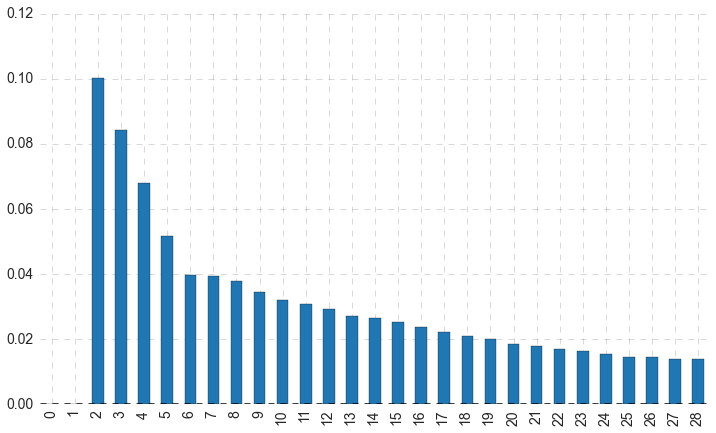

In [12]:
df_kmeans_higgs.score.plot(kind='bar')

In [ ]:
df_kmeans_converters.score.plot()

You can choose your own measures of distance/similarity. Naturally, you'll have to justify your choices

### Expectation Maximization

In [106]:
from algo_evaluation.clustering import gmm_eval
reload(gmm_eval)

<module 'algo_evaluation.clustering.gmm_eval' from '/Users/maestro/schoolspace/bag-of-algorithms/algo_evaluation/clustering/gmm_eval.pyc'>

In [107]:
df_h = gmm_eval.estimate_clusters(higgs_data)

ValueError: scoring must return a number, got [-37.72372952 -36.34718761 -37.20833615 ..., -38.93720954 -34.18017769
 -44.98166283] (<type 'numpy.ndarray'>) instead.

In [ ]:
df_c = gmm_eval.estimate_clusters(bid_data)

In [ ]:
df_h

In [ ]:
df_c

### Feature Selection

In the previous analysis Higgs records were sampled and features were manually pruned due to the slow speed of supervized algorithms. In this analysis, complete dataset is restored to take advantage of automatic feature selection using dimensionality reduction algorithms.

Dimensionality reduction is the task of deriving a set of features that is smaller than the original feature set while retaining most of the variance of the original data. 
To estimate the best number of components to be used for data transformation, I used PCA and ExtraTreeClassifier to rank the features and choose what seems to be optimal.

In [85]:
from algo_evaluation.feature_selection import pca_eval, extra_tree_eval
reload(pca_eval)

<module 'algo_evaluation.feature_selection.pca_eval' from '/Users/maestro/schoolspace/bag-of-algorithms/algo_evaluation/feature_selection/pca_eval.py'>

In [81]:
pca_rank = pca_eval.rank_features(higgs_data, n_components=all_higgs_features)

In [ ]:
extra_tree_rank = extra_tree_eval.rank_features(higgs_data, n_estimators=all_higgs_features)

Using __PCA__, I extracted variances for each feature and sorted them from largest to smallest. Visualizing the results made it clear that "Derived" features have larger spread than "Primitives" and thus are more informative for classification. This supports the decision made in the previous analysis where "Primitive" features were pruned based on feature by feature analysis.

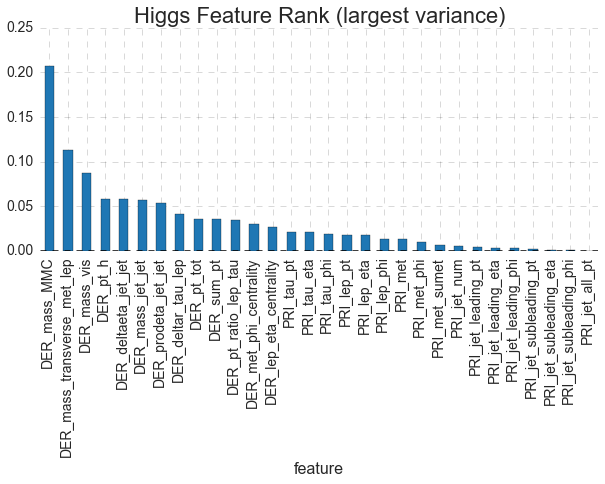

In [82]:
pca_eval.plot_rank(pca_rank)

Visual inspection of the PCA feature ranking suggests that the best number of components could be selected as __7__. To confirm this selection I applied __ExtraTreesClassifier__, which implements a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.
Note that both algorithms ranked DER_mass_MMC the highest which makes sense since this feature estimates mass of the Higgs boson candidate and indeed is the most informative.

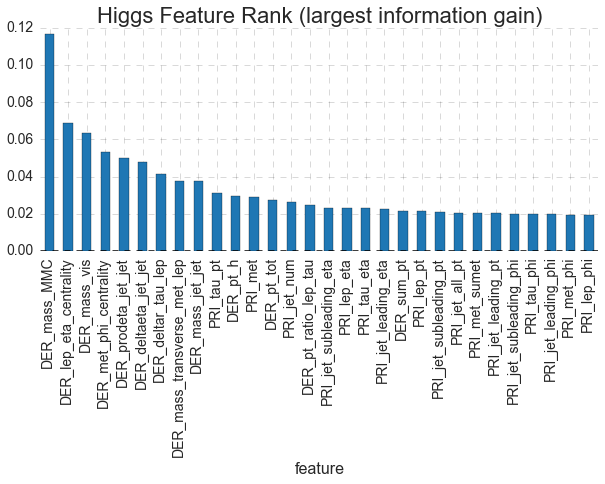

In [24]:
extra_tree_eval.plot_rank(extra_tree_rank)

### Component Number Estimation

In [86]:
pca_comp = pca_eval.estimate_components(higgs_data)

In [90]:
rp_comp = rand_projections.estimate_components(higgs_data)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator SparseRandomProjection(dense_output=False, density='auto', eps=0.1,
            n_components=0, random_state=None) does not.

In [91]:
ica_comp = ica_eval.estimate_components(higgs_data)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=0, random_state=None, tol=0.0001, w_init=None,
    whiten=True) does not.

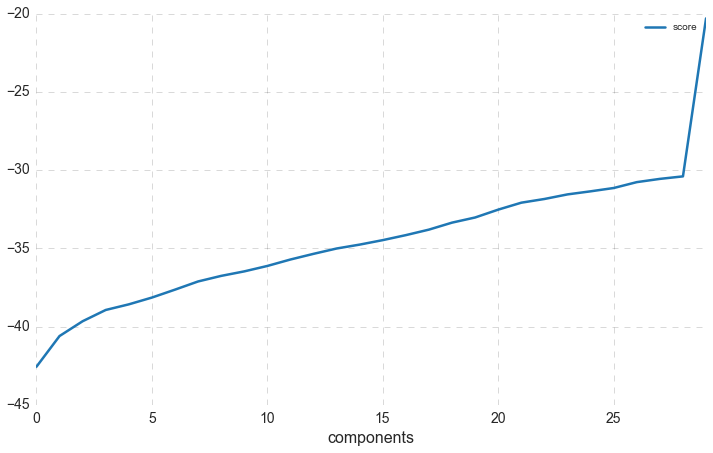

In [88]:
pca_comp.set_index('components').plot()

### Feature Transformation

Having estimated number of componets, now I can actually run the transformation to reduce the dimension of the Higgs data.

In [89]:
from algo_evaluation.feature_selection import rand_projections, ica_eval
reload(rand_projections)
reload(ica_eval)
reload(pca_eval)
reload(extra_tree_eval)

<module 'algo_evaluation.feature_selection.extra_tree_eval' from '/Users/maestro/schoolspace/bag-of-algorithms/algo_evaluation/feature_selection/extra_tree_eval.pyc'>

In [72]:
pca_trns, pca_elapsed = pca_eval.transform(higgs_data, n_components=7)

In [75]:
rand_proj_trns, rand_proj_elapsed = rand_projections.transform(higgs_data, n_components=7)

In [49]:
ica_trns, ica_elapsed = ica_eval.transform(higgs_data, n_components=7)

In [69]:
tree_trns, tree_elapsed = extra_tree_eval.transform(higgs_data, n_components=7)

### Neural Networks with reduced Higgs data dimension

In [79]:
from algo_evaluation.supervised import neural_network as nn

In [46]:
def reduced_higgs(transformed):
    return {'features': transformed, 'weights':higgs_data[1], 'labels': higgs_data[2]}

In [47]:
df_nn_pca = nn.run_neural_net(reduced_higgs(pca_trns))

In [50]:
df_nn_ica = nn.run_neural_net(reduced_higgs(ica_trns))

In [70]:
df_nn_tree = nn.run_neural_net(reduced_higgs(tree_trns))

In [77]:
df_nn_rp = nn.run_neural_net(reduced_higgs(rand_proj_trns))

In [51]:
df_nn_pca

(5, 29.478920150758174, 29.210783877569177)

In [52]:
df_nn_ica

(5, 34.30624945218687, 34.90968947415251)

In [71]:
df_nn_tree

(5, 29.868963099307564, 30.456446303051873)

In [78]:
df_nn_rp

(5, 34.30405819966693, 34.1267016638491)

You are to run a number of experiments. Come up with at least two datasets

Run the clustering algorithms on the data sets and describe what you see

Apply the dimensionality reduction algorithms to the two datasets and describe what you see.

Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it.

Apply the dimensionality reduction algorithms to one of your datasets from assignment #1

and rerun your neural network learner on the newly projected data

Apply the clustering algorithms to the same dataset to which you just applied the dimensionality reduction algorithms (you've probably already done this), treating the clusters as if they were new features. In other words, treat the clustering algorithms as if they were dimensionality reduction algorithms. Again, rerun your neural network learner on the newly projected data.


A discussion of your datasets, and why they're interesting: If you're using the same datasets as before at least briefly remind us of what they are so we don't have to revisit your old assignment write-up.
explanations of your methods: How did you choose k?
a description of the kind of clusters that you got.
analyses of your results. Why did you get the clusters you did? Do they make "sense"? If you used data that already had labels (for example data from a classification problem from assignment #1) did the clusters line up with the labels? Do they otherwise line up naturally? Why or why not? Compare and contrast the different algorithms. What sort of changes might you make to each of those algorithms to improve performance? How much performance was due to the problems you chose? Be creative and think of as many questions you can, and as many answers as you can. Take care to justify your analysis with data explictly.
Can you describe how the data look in the new spaces you created with the various aglorithms? For PCA, what is the distribution of eigenvalues? For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?
When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA and RP, did you get the same clusters as before? Different clusters? Why? Why not?
When you re-ran your neural network algorithms were there any differences in performance? Speed? Anything at all?
It might be difficult to generate the same kinds of graphs for this part of the assignment as you did before; however, you should come up with some way to describe the kinds of clusters you get. If you can do that visually all the better.
